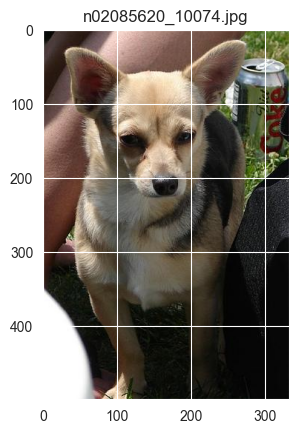

<annotation>
	<folder>02085620</folder>
	<filename>n02085620_10074</filename>
	<source>
		<database>ImageNet database</database>
	</source>
	<size>
		<width>333</width>
		<height>500</height>
		<depth>3</depth>
	</size>
	<segment>0</segment>
	<object>
		<name>Chihuahua</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>25</xmin>
			<ymin>10</ymin>
			<xmax>276</xmax>
			<ymax>498</ymax>
		</bndbox>
	</object>
</annotation>


In [1]:
import os
from PIL import Image
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

extract_path = r"..\..\data\raw"  


# Define paths
path_image_folder = os.path.join(extract_path, 'images/Images')
path_annotation_folder = os.path.join(extract_path, 'annotations/Annotation')

# List breeds
list_breeds = os.listdir(path_image_folder)

# Explore image and annotation samples
sample_breed = list_breeds[0]
sample_image_folder = os.path.join(path_image_folder, sample_breed)
sample_annotation_folder = os.path.join(path_annotation_folder, sample_breed)

sample_image = os.listdir(sample_image_folder)[0]
sample_annotation = os.listdir(sample_annotation_folder)[0]

# Load and display image
img_path_sample = os.path.join(sample_image_folder, sample_image)
img_sample = Image.open(img_path_sample)
plt.imshow(img_sample)
plt.title(sample_image)
plt.show()

# Load and display annotation details
ann_path = os.path.join(sample_annotation_folder, sample_annotation)
tree = ET.parse(ann_path)
ET.dump(tree)


# number of images and breeds

In [2]:
# Count the number of images and breeds
num_breeds = len(list_breeds)
print(f"Number of breeds: {num_breeds}")

num_images = sum([len(os.listdir(os.path.join(path_image_folder, breed))) for breed in list_breeds])
print(f"Number of images: {num_images}")


Number of breeds: 120
Number of images: 20580


# Average image size

In [3]:
from PIL import Image
import numpy as np

image_sizes = []
for breed in list_breeds:
    breed_folder = os.path.join(path_image_folder, breed)
    for img_name in os.listdir(breed_folder):
        img_path = os.path.join(breed_folder, img_name)
        with Image.open(img_path) as img:
            image_sizes.append(img.size)

average_image_size = np.mean(image_sizes, axis=0)
print(f"Average image size: {average_image_size}")


Average image size: [442.53187561 385.86122449]


# Plot distribution of image sizes

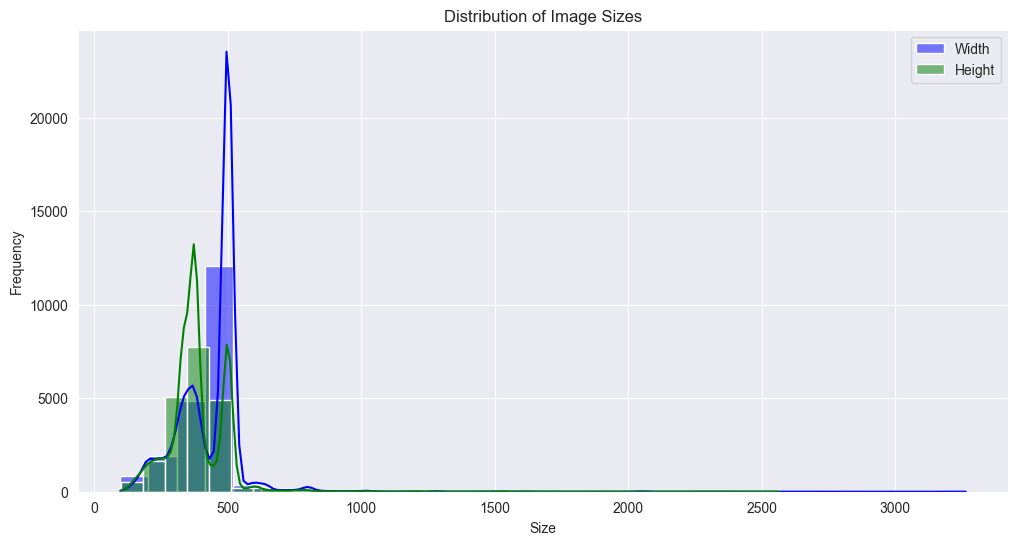

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

image_widths = [size[0] for size in image_sizes]
image_heights = [size[1] for size in image_sizes]

plt.figure(figsize=(12, 6))

sns.histplot(image_widths, bins=30, kde=True, color='blue', label='Width', alpha=0.5)

sns.histplot(image_heights, bins=30, kde=True, color='green', label='Height', alpha=0.5)

plt.xlabel('Size')
plt.ylabel('Frequency')
plt.title('Distribution of Image Sizes')
plt.legend()
plt.show()


# Label distribution

In [5]:
from collections import Counter

labels = []
for breed in list_breeds:
    breed_folder = os.path.join(path_annotation_folder, breed)
    for ann_name in os.listdir(breed_folder):
        ann_path = os.path.join(breed_folder, ann_name)
        tree = ET.parse(ann_path)
        root = tree.getroot()
        label = root.find('object').find('name').text
        labels.append(label)

label_counts = Counter(labels)
print(f'Label distribution: {label_counts}')


Label distribution: Counter({'Maltese_dog': 252, 'Afghan_hound': 239, 'Scottish_deerhound': 232, 'Pomeranian': 219, 'Irish_wolfhound': 218, 'Bernese_mountain_dog': 218, 'Samoyed': 218, 'Shih-Tzu': 214, 'Great_Pyrenees': 213, 'Leonberg': 210, 'basenji': 209, 'Tibetan_terrier': 206, 'Sealyham_terrier': 202, 'Airedale': 202, 'EntleBucher': 202, 'Saluki': 200, 'pug': 200, 'Lakeland_terrier': 197, 'cairn': 197, 'papillon': 196, 'Norwegian_elkhound': 196, 'Australian_terrier': 196, 'chow': 196, 'beagle': 195, 'Newfoundland': 195, 'Siberian_husky': 192, 'Blenheim_spaniel': 188, 'Ibizan_hound': 188, 'bloodhound': 187, 'whippet': 187, 'Lhasa': 186, 'Japanese_spaniel': 185, 'Norwich_terrier': 185, 'miniature_pinscher': 184, 'silky_terrier': 183, 'Italian_greyhound': 182, 'Bedlington_terrier': 182, 'Boston_bull': 182, 'Pembroke': 181, 'Dandie_Dinmont': 180, 'Kerry_blue_terrier': 179, 'malamute': 178, 'basset': 175, 'toy_terrier': 172, 'Rhodesian_ridgeback': 172, 'Border_terrier': 172, 'Norfolk_te

# Load YOLOv5 model and detect bounding boxes

Define functions

In [6]:
import torch
from yolov5 import YOLOv5
from PIL import Image
import pandas as pd
import numpy as np

model_path = r"..\..\weights\yolov5s.pt"
model = YOLOv5(model_path)  # Đảm bảo sử dụng thiết bị 'cuda' nếu có GPU

def detect_objects(img_path_2):
    img_2 = Image.open(img_path_2)
    results = model.predict(img_2)  
    print(results)  # In kết quả tạm thời để kiểm tra
    return results.xyxy[0].cpu().numpy()

def get_dog_coordinates(bounding_boxes, dog_class_id=16):
    # Lọc bounding boxes chỉ chứa class của chó
    dog_boxes = bounding_boxes[bounding_boxes[:, 5] == dog_class_id]
    # Chuyển bounding boxes thành DataFrame
    df = pd.DataFrame(dog_boxes, columns=['x1', 'y1', 'x2', 'y2', 'confidence', 'class'])
    return df

def get_annotation_bounding_boxes(ann_path):
    tree = ET.parse(ann_path)
    root = tree.getroot()
    boxes = []
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        boxes.append([xmin, ymin, xmax, ymax])
    return np.array(boxes)

# DataFrame để lưu trữ bounding boxes
all_dog_coordinates_df = pd.DataFrame()

image_folder = os.path.join(extract_path, 'images/Images')
breeds = os.listdir(image_folder)



YOLOv5  2024-7-28 Python-3.8.19 torch-1.13.1+cu116 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)

Fusing layers... 
YOLOv5s summary: 270 layers, 7235389 parameters, 0 gradients
Adding AutoShape... 


detect dog by yolov5

In [7]:
# Vòng lặp qua tất cả các giống chó
for breed in breeds:
    breed_folder = os.path.join(image_folder, breed)
    images = os.listdir(breed_folder)
    
    for img_name in images:
        img_path = os.path.join(breed_folder, img_name)
        bounding_boxes = detect_objects(img_path)
        dog_coordinates_df = get_dog_coordinates(bounding_boxes)
        
        if not dog_coordinates_df.empty:
            dog_coordinates_df['image_path'] = img_path
            all_dog_coordinates_df = pd.concat([all_dog_coordinates_df, dog_coordinates_df], ignore_index=True)

image 1/1: 500x333 1 dog
Speed: 11.3ms pre-process, 47.7ms inference, 26.2ms NMS per image at shape (1, 3, 640, 448)
image 1/1: 495x395 1 cow
Speed: 4.0ms pre-process, 37.7ms inference, 1.0ms NMS per image at shape (1, 3, 640, 512)
image 1/1: 298x500 1 person, 1 dog
Speed: 1.0ms pre-process, 15.1ms inference, 2.4ms NMS per image at shape (1, 3, 384, 640)
image 1/1: 500x345 1 dog
Speed: 3.1ms pre-process, 16.5ms inference, 10.0ms NMS per image at shape (1, 3, 640, 448)
image 1/1: 484x322 1 dog
Speed: 1.5ms pre-process, 12.0ms inference, 1.3ms NMS per image at shape (1, 3, 640, 448)
image 1/1: 375x500 1 cat
Speed: 3.9ms pre-process, 14.0ms inference, 1.0ms NMS per image at shape (1, 3, 480, 640)
image 1/1: 384x382 1 person, 1 dog
Speed: 3.0ms pre-process, 31.4ms inference, 2.0ms NMS per image at shape (1, 3, 640, 640)
image 1/1: 500x375 1 dog, 1 teddy bear
Speed: 3.0ms pre-process, 15.6ms inference, 3.4ms NMS per image at shape (1, 3, 640, 480)
image 1/1: 225x300 (no detections)
Speed: 2

In [8]:
# Lưu DataFrame chứa tất cả bounding boxes vào CSV
output_folder = r'..\..\data\processed'
os.makedirs(output_folder, exist_ok=True)
bbox_csv_path = os.path.join(output_folder, 'all_dog_bounding_boxes.csv')
all_dog_coordinates_df.to_csv(bbox_csv_path, index=False)

print(f"Bounding boxes saved to {bbox_csv_path}")

# Hiển thị một số dòng đầu tiên của DataFrame
print(all_dog_coordinates_df.head())

Bounding boxes saved to ..\..\data\processed\all_dog_bounding_boxes.csv
           x1          y1          x2          y2  confidence  class  \
0   26.319031    7.225728  276.857330  500.000000    0.745121   16.0   
1  150.661285   46.706070  336.773499  251.114059    0.841461   16.0   
2    5.783877   26.090622  323.815613  500.000000    0.830568   16.0   
3   89.241531  108.202042  257.235474  450.949097    0.905361   16.0   
4  115.464676  227.659622  232.972183  363.290375    0.336901   16.0   

                                          image_path  
0  ..\..\data\raw\images/Images\n02085620-Chihuah...  
1  ..\..\data\raw\images/Images\n02085620-Chihuah...  
2  ..\..\data\raw\images/Images\n02085620-Chihuah...  
3  ..\..\data\raw\images/Images\n02085620-Chihuah...  
4  ..\..\data\raw\images/Images\n02085620-Chihuah...  


# collect all boundary box of all ann-files

In [9]:
# Lấy bounding box từ annotation
bbox_sizes_ann = []
all_annotation_boxes = pd.DataFrame()

for breed in list_breeds:
    breed_folder = os.path.join(path_annotation_folder, breed)
    for ann_name in os.listdir(breed_folder):
        ann_path = os.path.join(breed_folder, ann_name)
        tree = ET.parse(ann_path)
        root = tree.getroot()
        
        bbox = root.find('object').find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        
        width = xmax - xmin
        height = ymax - ymin
        bbox_sizes_ann.append((xmin, ymin, xmax, ymax))
        
        # Sử dụng pd.concat thay vì append
        temp_df = pd.DataFrame([{'x1': xmin, 'y1': ymin, 'x2': xmax, 'y2': ymax, 'breed': breed, 'ann_path': ann_path}])
        all_annotation_boxes = pd.concat([all_annotation_boxes, temp_df], ignore_index=True)
        
# Hiển thị thống kê cơ bản
print(all_annotation_boxes.describe())

# Save DataFrame of bounding boxes to CSV
bbox_csv_path = os.path.join(output_folder, 'all_bounding_boxes.csv')
all_annotation_boxes.to_csv(bbox_csv_path, index=False)

print(f"Bounding boxes saved to {bbox_csv_path}")


                 x1            y1            x2            y2
count  20580.000000  20580.000000  20580.000000  20580.000000
mean      76.541011     56.541351    365.581681    354.171283
std       75.279383     59.406210    129.140475    122.409322
min        0.000000      0.000000     71.000000     90.000000
25%       15.000000     13.000000    291.000000    289.000000
50%       57.000000     39.000000    359.000000    339.000000
75%      120.000000     82.000000    439.000000    399.000000
max     1230.000000   1548.000000   2735.000000   2457.000000
Bounding boxes saved to ..\..\data\processed\all_bounding_boxes.csv


# collect all list image path 

In [10]:
# Lấy bounding box từ annotation

# Initialize a dictionary to store image paths
dic_image_paths = {"all_image_path": []}

# Loop through each breed to get image paths
for breed in list_breeds:
    breed_folder = os.path.join(path_image_folder, breed)
    images = os.listdir(breed_folder)
    
    for img_name in images:
        img_path = os.path.join(breed_folder, img_name)
        dic_image_paths["all_image_path"].append(img_path)  # Append image path to the list

# Convert dictionary to DataFrame for image paths
df_image_paths = pd.DataFrame(dic_image_paths)

print(df_image_paths.shape)

# Save DataFrame of image paths to CSV
output_folder = r'..\..\data\processed'
os.makedirs(output_folder, exist_ok=True)
all_image_path_csv = os.path.join(output_folder, 'all_image_paths.csv')
df_image_paths.to_csv(all_image_path_csv, index=False)

print(f"Image paths saved to {all_image_path_csv}")

(20580, 1)
Image paths saved to ..\..\data\processed\all_image_paths.csv


 - merge all_image_paths and all_ann_paths

In [11]:
import pandas as pd
import os

# Đọc file CSV chứa đường dẫn ảnh
all_image_path_csv = r'..\..\data\processed\all_image_paths.csv'
df_image_paths = pd.read_csv(all_image_path_csv)

# Đọc file CSV chứa bounding boxes
bbox_csv_path = r'..\..\data\processed\all_bounding_boxes.csv'
df_bounding_boxes = pd.read_csv(bbox_csv_path)

# Kiểm tra số lượng hàng trong mỗi DataFrame
assert len(df_image_paths) == len(df_bounding_boxes), "Số lượng hàng trong hai DataFrame không khớp."

# Kết hợp hai DataFrame theo thứ tự
combined_df = pd.concat([df_image_paths, df_bounding_boxes], axis=1)

# Lưu DataFrame kết hợp vào một file CSV mới
combined_csv_path = os.path.join(r'..\..\data\processed', 'combined_image_paths_and_boxes.csv')
combined_df.to_csv(combined_csv_path, index=False)

print(f"Combined data saved to {combined_csv_path}")


Combined data saved to ..\..\data\processed\combined_image_paths_and_boxes.csv


In [12]:
import pandas as pd

# Đọc hai file CSV
all_dog_bounding_boxes = pd.read_csv(r'..\..\data\processed\all_dog_bounding_boxes.csv')
combine_df = pd.read_csv(r'..\..\data\processed\combined_image_paths_and_boxes.csv')

# Đổi tên cột trong all_dog_bounding_boxes_df để khớp với combine_df
combine_df.rename(columns={'all_image_path': 'image_path'}, inplace=True)

# Thực hiện join dựa trên cột image_path
joined_df = pd.merge(all_dog_bounding_boxes, combine_df, on='image_path', how='inner')

# Lưu kết quả vào file CSV mới
output_path = r'..\..\data\processed\joined_data.csv'
joined_df.to_csv(output_path, index=False)

print(f"Joined data saved to {output_path}")


Joined data saved to ..\..\data\processed\joined_data.csv


# Calculate IoU and identify outliers

In [13]:
import pandas as pd

# Hàm tính IoU
def calculate_iou(box1, box2):
    x1_max = max(box1[0], box2[0])
    y1_max = max(box1[1], box2[1])
    x2_min = min(box1[2], box2[2])
    y2_min = min(box1[3], box2[3])
    
    inter_width = max(0, x2_min - x1_max)
    inter_height = max(0, y2_min - y1_max)
    inter_area = inter_width * inter_height
    
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union_area = box1_area + box2_area - inter_area
    
    iou = inter_area / union_area if union_area != 0 else 0
    
    return iou

# Đọc dữ liệu đã được merge
merged_df = pd.read_csv(r'..\..\data\processed\joined_data.csv')

# Tính toán IoU cho mỗi hàng trong DataFrame
ious = []
for index, row in merged_df.iterrows():
    box1 = [row['x1_x'], row['y1_x'], row['x2_x'], row['y2_x']]
    box2 = [row['x1_y'], row['y1_y'], row['x2_y'], row['y2_y']]
    iou = calculate_iou(box1, box2)
    ious.append(iou)

# Thêm cột IoU vào DataFrame
merged_df['iou'] = ious

# Xác định outliers (ví dụ: IoU < 0.5)
iou_threshold = 0.5
outliers = merged_df[merged_df['iou'] < iou_threshold]

# Lưu kết quả vào file CSV
outliers_csv_path = r'..\..\data\processed\outliers.csv'
outliers.to_csv(outliers_csv_path, index=False)

print(f"Outliers saved to {outliers_csv_path}")
print(outliers.head())


Outliers saved to ..\..\data\processed\outliers.csv
          x1_x       y1_x       x2_x       y2_x  confidence  ...  x2_y y2_y  \
4   115.464676  227.65962  232.97218  363.29037    0.336901  ...   145  383   
7   149.419540   71.64194  329.21110  322.30370    0.631273  ...   156  225   
16    1.080162   73.38074  454.30444  305.04070    0.278895  ...   438  230   
37  282.858760  281.88812  373.89606  497.56604    0.301627  ...   327  498   
38  189.627080  109.07716  270.22595  210.59525    0.793004  ...   350  223   

                  breed                                           ann_path  \
4   n02085620-Chihuahua  ..\..\data\raw\annotations/Annotation\n0208562...   
7   n02085620-Chihuahua  ..\..\data\raw\annotations/Annotation\n0208562...   
16  n02085620-Chihuahua  ..\..\data\raw\annotations/Annotation\n0208562...   
37  n02085620-Chihuahua  ..\..\data\raw\annotations/Annotation\n0208562...   
38  n02085620-Chihuahua  ..\..\data\raw\annotations/Annotation\n0208562...   

    

# Vissualize IoU

In [14]:
# import matplotlib.pyplot as plt
# import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(merged_df['iou'], bins=30, kde=True)
plt.xlabel('IoU')
plt.ylabel('Frequency')
plt.title('Distribution of IoU Values')
plt.savefig(r'..\..\output\preprocess\distribution_of_iou_values.png')
plt.show()


In [15]:
import matplotlib.patches as patches

# Chọn một hình ảnh ví dụ để hiển thị bounding boxes
sample_image_path = merged_df.iloc[0]['image_path']
img = Image.open(sample_image_path)

fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(img)

# Bounding box từ YOLO
box1 = merged_df.iloc[0][['x1_x', 'y1_x', 'x2_x', 'y2_x']].values
rect1 = patches.Rectangle((box1[0], box1[1]), box1[2] - box1[0], box1[3] - box1[1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect1)

# Bounding box từ annotation
box2 = merged_df.iloc[0][['x1_y', 'y1_y', 'x2_y', 'y2_y']].values
rect2 = patches.Rectangle((box2[0], box2[1]), box2[2] - box2[0], box2[3] - box2[1], linewidth=2, edgecolor='b', facecolor='none')
ax.add_patch(rect2)

plt.title(f'Bounding Boxes for {sample_image_path}')

plt.savefig(r'..\..\output\preprocess\bounding_boxes_image.png')

plt.show()


# Clustering

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Extract bounding boxes for clustering
bounding_boxes = merged_df[['x1_x', 'y1_x', 'x2_x', 'y2_x']].values

# Find the optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)  # Set n_init explicitly to avoid warning
    kmeans.fit(bounding_boxes)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), wcss, marker='o')
plt.title('Elbow Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

plt.savefig(r'..\..\output\preprocess\Elbow_Graph_NumberOfCluster.png')
plt.show()

# Perform clustering with the optimal number of clusters (e.g., 5)
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)  # Set n_init explicitly to avoid warning
merged_df['cluster'] = kmeans.fit_predict(bounding_boxes)


- Based on the Elbow graph, it is clear that from \( k = 1 \) to \( k = 5 \), there is a significant drop in the Within-Cluster Sum of Squares (WCSS). However, after \( k = 5 \), the decrease in WCSS slows down, indicating that increasing the number of clusters beyond 5 does not provide significant benefits in reducing WCSS. This suggests that 5 is the optimal number of clusters.

Therefore, based on the Elbow graph, you should choose 5 as the number of clusters.

# Remove Outliers

In [17]:
# Xác định outliers dựa trên cột IoU
iou_threshold = 0.5
outliers = merged_df[merged_df['iou'] < iou_threshold]

# Lưu outliers vào file CSV
outliers_csv_path = r'..\..\data\processed\outliers.csv'
outliers.to_csv(outliers_csv_path, index=False)

# Lưu dữ liệu không chứa outliers vào file CSV
filtered_df = merged_df[merged_df['iou'] >= iou_threshold]
filtered_csv_path = r'..\..\data\processed\filtered_data.csv'
filtered_df.to_csv(filtered_csv_path, index=False)

print(f"Outliers saved to {outliers_csv_path}")
print(f"Filtered data saved to {filtered_csv_path}")


Outliers saved to ..\..\data\processed\outliers.csv
Filtered data saved to ..\..\data\processed\filtered_data.csv


# Visualization of the Clustering result and Outliers

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the clustering result
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_df, x='x1_x', y='y1_x', hue='cluster', palette='Set1')
plt.title('Clusters of Bounding Boxes')
plt.savefig(r'..\..\output\preprocess\clustering_result.png')  # Save the clustering result
plt.show()

# Visualize the outliers
plt.figure(figsize=(12, 6))
sns.scatterplot(data=outliers, x='x1_x', y='y1_x', hue='cluster', palette='Set1', marker='x')
plt.title('Outliers of Bounding Boxes')

plt.savefig(r'..\..\output\preprocess\outliers_result.png')  # Save the outliers result
plt.show()
